### Analysis of real data - power spectral density
    * data has 4 channels from the heterodyning ( frequency mixing), time stamps are slightly different for each channel - large files so don’t read in whole thing (try 10,000 points) - the frequencies are important so the whole time series is not required
    * try and replicate the plot given (power spectral density plot) - apparently the normalisations are difficult and important 
    
Data is on USB - the 3 files with roman/arabic numerals are consecutive.
Begin with the run-43 file
-read in data
-remove header lines 
run-43 has 28929007 lines and the first 7 are info: 28929000 lines of data in 4 columns 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline



#read in 10,000 lines of data         X0   Y0   X1   Y1

#the data is the signal in Volts, but the callibration is not clear yet so take as arbitrary units
#skips the first 7 rows and places the next 10000 in a numpy array

data43 = np.loadtxt(fname = 'dataFiles/run-43', skiprows = 7, max_rows = 4000000)




In [2]:
len(data43)

4000000

In [3]:
#time step (seconds)
dt = 0.01
#make a time series the same length as the read-in data
t_s = np.arange(0,len(data43)*dt,dt) 

Text(0, 0.5, 'amplitude')

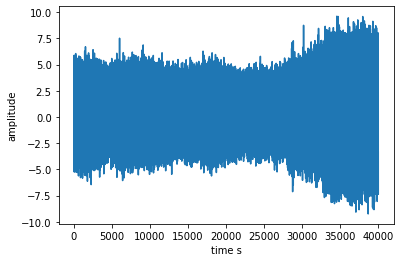

In [4]:
#now plot the first column of the data in time domain
plt.plot(t_s,data43[:,0])
plt.xlabel("time s")
plt.ylabel("amplitude")

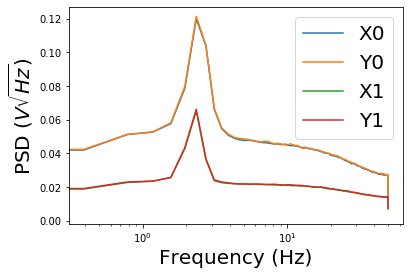

In [5]:
#use signal.welch to estimate power spectral density using Welch’s method
#freqs - Array of sample frequencies.
#psd - Power spectral density or power spectrum of x.

#make dicts for the output of the function
freqs = []
psd = []
for i in range(4):
    f , p = signal.welch(x = data43[:,i], fs = 1/dt)
    freqs.append(f)
    psd.append(p)
    #make y axis scale decibel volts dBV(sqrtHz)
    #p = 20*np.log10(p)
    plt.semilogx(f, p) 
    
plt.xlabel('Frequency (Hz)',fontsize=20)
plt.ylabel('PSD ($V\sqrt{Hz}$)',fontsize=20)
plt.legend(["X0","Y0","X1","Y1"],fontsize=20)
plt.rcParams["figure.figsize"] = (10,7)





"A voltage decibel (dBV) is a unit of measurement of the ratio of an amount of voltage V to V0 = 1 volt given by the formula 20 log10(V/ V0) = 20 log10(V)."

Text(0, 0.5, 'PSD ($V\\sqrt{Hz}$)')

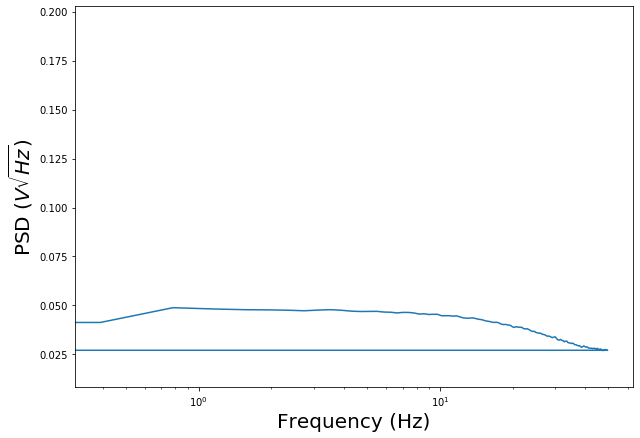

In [6]:
#Try to do 2 sided psd with X+iY 
#start with X0 and Y0

X0 = data43[:,0]
Y0 = data43[:,1]
iY0 = 1j*Y0
#combine x+iy to make complex signal
sig_0 = X0+iY0
#make psd
f_sig0 , p_sig0 = signal.welch(x = sig_0, fs = 1/dt, return_onesided = False)
plt.semilogx(f_sig0, p_sig0) 
plt.xlabel('Frequency (Hz)',fontsize=20)
plt.ylabel('PSD ($V\sqrt{Hz}$)',fontsize=20)
#plt.ylim(0.02,0.05)


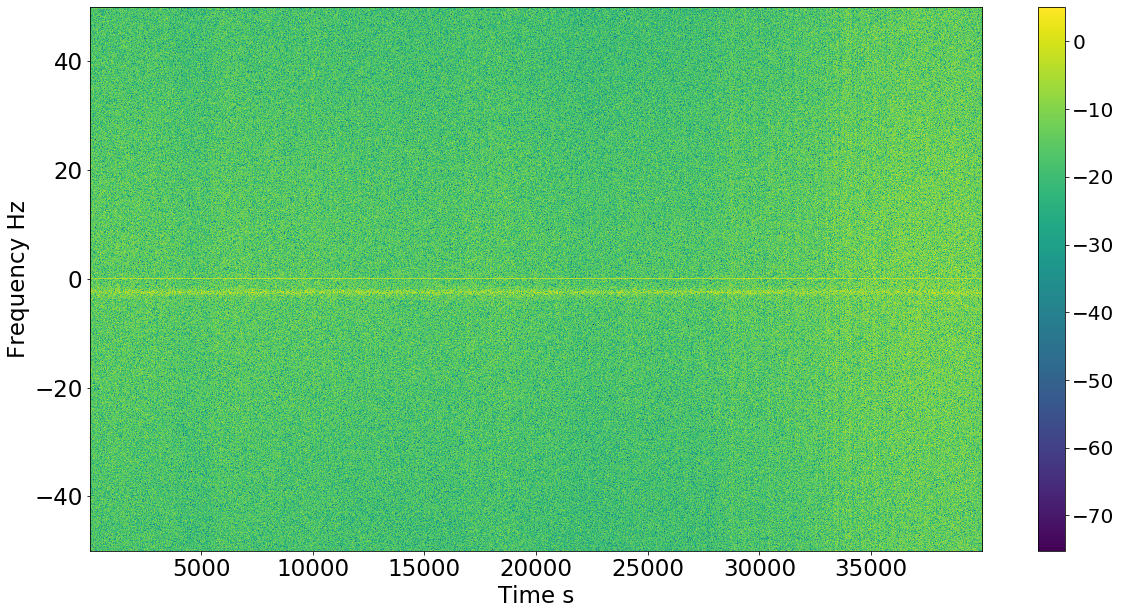

In [7]:
#Differencing
#first make spectrogram of X0+iY0
plt.figure(figsize=(20,10))

spectrum, freqs, t_bins, im = plt.specgram(x=sig_0, Fs=1/dt, NFFT = 2000)

plt.ylabel("Frequency Hz",fontsize=23)
plt.xlabel("Time s",fontsize=23)
cbar = plt.colorbar(im);
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
cbar.ax.tick_params(labelsize=20)



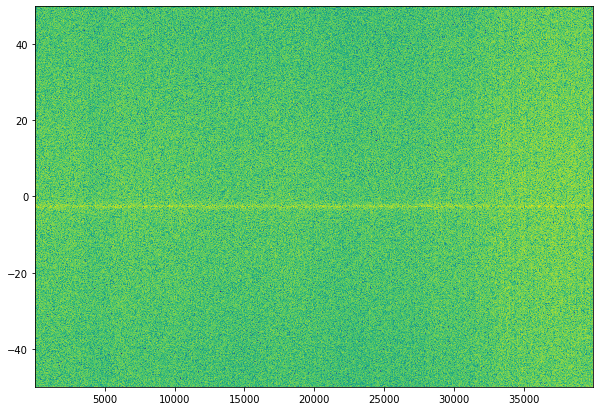

In [8]:
#try to replicate spec image with pcolormesh

plt.pcolormesh(t_bins, freqs, 10 * np.log10(spectrum))

In [9]:
#normalise spectrum powers
#find average of each row in spectrum

#dimensions
[ydim,xdim] = np.shape(spectrum)
'''
#initialise array
norm_spectrum = np.ones(np.shape(spectrum))

#loop over every row in the array, add the elements in each and divide every element by the average
for row in range(len(spectrum)):
    #sum the rows
    sum_row = np.sum(spectrum[row])
    
    #divide sum by number of elements in row
    ave_row = sum_row/xdim
    
    #divide row by row average to normalise
    norm_row = spectrum[row]/sum_row
    
    norm_spectrum[row,:] = norm_row
#plt.pcolormesh(bins, freqs, 20 * np.log10(norm_spectrum))

np.shape(norm_spectrum)
'''

'\n#initialise array\nnorm_spectrum = np.ones(np.shape(spectrum))\n\n#loop over every row in the array, add the elements in each and divide every element by the average\nfor row in range(len(spectrum)):\n    #sum the rows\n    sum_row = np.sum(spectrum[row])\n    \n    #divide sum by number of elements in row\n    ave_row = sum_row/xdim\n    \n    #divide row by row average to normalise\n    norm_row = spectrum[row]/sum_row\n    \n    norm_spectrum[row,:] = norm_row\n#plt.pcolormesh(bins, freqs, 20 * np.log10(norm_spectrum))\n\nnp.shape(norm_spectrum)\n'

In [18]:
#Alternate normalisation attempt
#find largest amplitude pixel and divide all pixels by this value

#largest pixel value in spectrum array
max_spectrum_val = np.median(spectrum)


#divide array by max value
norm_spectrum = spectrum / max_spectrum_val


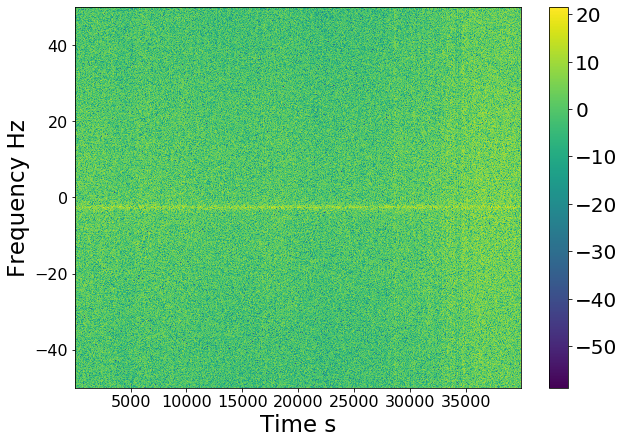

In [24]:
#spectrogram with normalised powers
#plt.plot(bins,freqs)
'''plt.figure(figsize=(20,10))
plt.imshow(spectrum)
cbar = plt.colorbar();'''
plt.pcolormesh(t_bins, freqs, 10 * np.log10(norm_spectrum))

plt.ylabel("Frequency Hz",fontsize=23)
plt.xlabel("Time s",fontsize=23)
cbar = plt.colorbar();
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

cbar.ax.tick_params(labelsize=20)


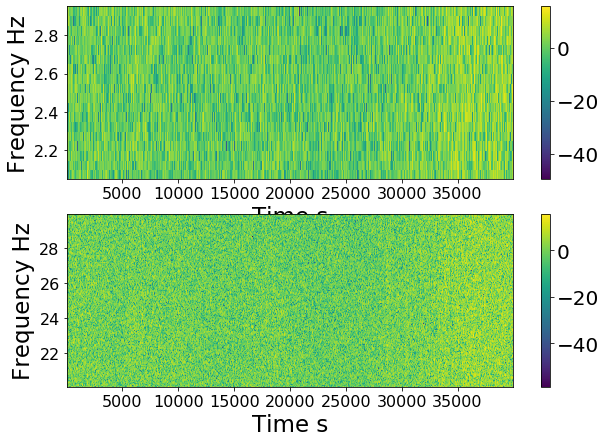

In [29]:
#Frequency slicing
#need to take frequencies in the resonant mode roughly 2-4Hz and one ouside this range eg. 30-40Hz

def freq_slice(min_freq, max_freq, freqs, t_bins, norm_spectrum):
    '''function slices the array containing the frequency spectrum using the min and max boundaries,
    and the corresponding spectrum powers. It plots the slices specgram and returns slice spectrum.'''
    
    #find the elements in the array in the HZ range
    slice_freqs = freqs[(min_freq<freqs) & (freqs<max_freq)]
    #and their indicies
    slice_indices = np.where((min_freq<freqs) & (freqs<max_freq))

    #need the spectrum powers corresponding to these freqs
    slice_spectrum = norm_spectrum[slice_indices]
    #res_mode_tbins = t_bins[res_mode_indices]

    #now plot the spectrogram for this range
    plt.pcolormesh(t_bins, slice_freqs, 10 * np.log10(slice_spectrum))
    
    
    plt.ylabel("Frequency Hz",fontsize=23)
    plt.xlabel("Time s",fontsize=23)
    cbar = plt.colorbar();
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    cbar.ax.tick_params(labelsize=20)
    
    return slice_spectrum
plt.figure
plt.subplot(211)
res_slice_spec = freq_slice(2,3, freqs=freqs, t_bins=t_bins, norm_spectrum=norm_spectrum)

plt.subplot(212)
bkgd_slice_spec = freq_slice(20,30, freqs=freqs, t_bins=t_bins, norm_spectrum=norm_spectrum)



In [26]:
#array containing the differences between successive columns of spectrogram data in spectrum

#difference array will have one fewer column 

#[ydim,xdim] = np.shape(spectrum)

#function
def difference(power_spectrum, spec_ydim, spec_xdim):
    
    diff_spec = np.ones((spec_ydim, spec_xdim -1))

    for i in range(spec_ydim):
        for j in range(spec_xdim-1):
            diff_spec[i,j] = power_spectrum[i,j+1] - power_spectrum[i,j]
    #square differences
    diff_spec = np.square(diff_spec)
    
    return diff_spec

#resonant mode slice:
res_diff_spec = difference(res_slice_spec, np.shape(res_slice_spec)[0], np.shape(res_slice_spec)[1])
bkgd_diff_spec = difference(bkgd_slice_spec,np.shape(bkgd_slice_spec)[0], np.shape(bkgd_slice_spec)[1])


'''diff_spec = np.ones((ydim, xdim -1))

for i in range(ydim):
    for j in range(xdim-1):
        diff_spec[i,j] = norm_spectrum[i,j+1] - norm_spectrum[i,j]
#square differences
diff_spec = np.square(diff_spec)'''

'diff_spec = np.ones((ydim, xdim -1))\n\nfor i in range(ydim):\n    for j in range(xdim-1):\n        diff_spec[i,j] = norm_spectrum[i,j+1] - norm_spectrum[i,j]\n#square differences\ndiff_spec = np.square(diff_spec)'

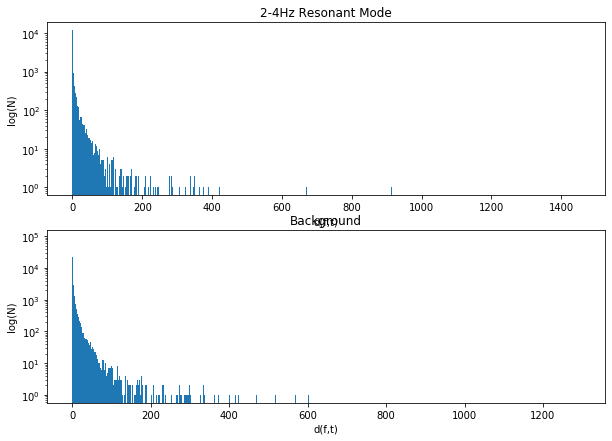

In [27]:
#slices histogram

def slice_hist(diff_spec, title):
    

    #want to plot all pixels so flatten array to 1D
    diff_spec = np.array(diff_spec).flatten()

    #Histogram of logN vs diff(f,t) - (N counts)

    n, bins, patches = plt.hist(x=diff_spec, bins='auto', log = True)# #color='#0504aa',
                            #alpha=0.7, #rwidth=0.85)
    
    plt.xlabel('d(f,t)')
    plt.ylabel('log(N)')
    plt.title(title)
    return

#plot hists of both slices

plt.subplot(211)
slice_hist(res_diff_spec, title = '2-4Hz Resonant Mode')

plt.subplot(212)
slice_hist(bkgd_diff_spec, title = 'Background')



In [23]:
'''#want to plot all pixels so flatten array to 1D
diff_spec = np.array(diff_spec).flatten()

#Histogram of logN vs diff(f,t) - (N counts)

n, bins, patches = plt.hist(x=diff_spec, bins='auto', log = True)# #color='#0504aa',
                            #alpha=0.7, #rwidth=0.85)
    
plt.xlabel('d(f,t)')
plt.ylabel('log(N)')

'''


"#want to plot all pixels so flatten array to 1D\ndiff_spec = np.array(diff_spec).flatten()\n\n#Histogram of logN vs diff(f,t) - (N counts)\n\nn, bins, patches = plt.hist(x=diff_spec, bins='auto', log = True)# #color='#0504aa',\n                            #alpha=0.7, #rwidth=0.85)\n    \nplt.xlabel('d(f,t)')\nplt.ylabel('log(N)')\n\n"